In [1]:
import os
import cv2
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

In [2]:
ROOT_DIR = os.getcwd()

# input path
Dataset_Dir = os.path.join(ROOT_DIR, 'car_dataset')

# read train/test set
name = os.path.join(ROOT_DIR, 'train_set.json')
with open(name, 'r') as file:
    train_files = json.load(file)
    
name = os.path.join(ROOT_DIR, 'test_set.json')
with open(name, 'r') as file:
    test_files = json.load(file)
    
print('train_files:', len(train_files))
print('test_files:', len(test_files))

train_files: 10000
test_files: 2063


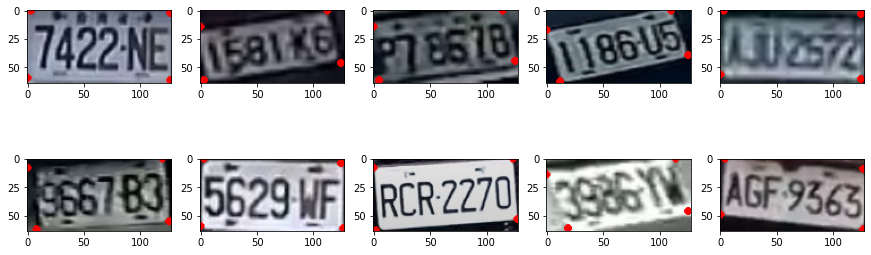

In [3]:
INPUT_SHAPE = (64, 128)

plt.figure(figsize=(15, 5))
for i in range(10):
    fname = train_files[i]
    im_file = osp.join(Dataset_Dir, fname+'.jpg')
    lb_file = osp.join(Dataset_Dir, fname+'.json')

    image = cv2.cvtColor(cv2.imread(im_file), cv2.COLOR_BGR2RGB)
    with open(lb_file, 'r') as f:
        data = json.load(f)
    box = np.array(data['車牌位置']).reshape(2, 2)
    label = np.array(data['車牌角點']).reshape(4, 2)

    image = image[box[0, 1]:box[1, 1]+1, box[0, 0]:box[1, 0]+1]
    resized_image = cv2.resize(image, INPUT_SHAPE[::-1])

    label -= box[0]
    resized_label = label.copy()
    resized_label[:, 0] = label[:, 0] / (image.shape[1]/INPUT_SHAPE[1])
    resized_label[:, 1] = label[:, 1] / (image.shape[0]/INPUT_SHAPE[0])

    draw_img = resized_image.copy()
    for x, y in resized_label:
        cv2.circle(draw_img, (x, y),  2, (255, 0, 0), 2)

    plt.subplot(2, 5, i+1); plt.imshow(draw_img)
plt.show()

In [7]:
INPUT_SHAPE = (64, 128, 3)

def save_npz(files, dtype):
    num_file = len(files)
    all_image = np.zeros((num_file,)+INPUT_SHAPE, np.float32)
    all_label = np.zeros((num_file, 8), np.float32)

    for i in tqdm(range(num_file), ncols=100, unit=' files'):
        fname = files[i]
        im_file = osp.join(Dataset_Dir, fname+'.jpg')
        lb_file = osp.join(Dataset_Dir, fname+'.json')

        image = cv2.cvtColor(cv2.imread(im_file), cv2.COLOR_BGR2RGB)
        with open(lb_file, 'r') as f:
            data = json.load(f)
        box = np.array(data['車牌位置']).reshape(2, 2)
        label = np.array(data['車牌角點']).reshape(4, 2)

        image = image[box[0, 1]:box[1, 1]+1, box[0, 0]:box[1, 0]+1]
        resized_image = cv2.resize(image, (INPUT_SHAPE[1], INPUT_SHAPE[0]))
        normalized_image = resized_image / 255

        label -= box[0]
        resized_label = label.copy()
        resized_label[:, 0] = label[:, 0] / (image.shape[1]/INPUT_SHAPE[1])
        resized_label[:, 1] = label[:, 1] / (image.shape[0]/INPUT_SHAPE[0])

        normalized_label = resized_label.copy().astype(np.float32)
        normalized_label[:, 0] = resized_label[:, 0] / (INPUT_SHAPE[1]-1)
        normalized_label[:, 1] = resized_label[:, 1] / (INPUT_SHAPE[0]-1)
        normalized_label = normalized_label.flatten()

        all_image[i] = normalized_image
        all_label[i] = normalized_label

    if dtype == 'train':
        np.savez_compressed(osp.join('npz', 'train_data.npz'),
                            train_image=all_image,
                            train_label=all_label)
    elif dtype == 'test':
        np.savez_compressed(osp.join('npz', 'test_data.npz'),
                            test_image=all_image,
                            test_label=all_label)
    
    print(f'{dtype} npz file saved.')

In [8]:
save_npz(train_files, 'train')
save_npz(test_files, 'test')

  0%|                                                          | 4/2063 [00:00<01:46, 19.42 files/s]

train npz file saved.


100%|███████████████████████████████████████████████████████| 2063/2063 [00:34<00:00, 59.92 files/s]


test npz file saved.


In [1]:
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
train_data = np.load(osp.join('npz', 'train_data.npz'))
train_image = train_data['train_image']
train_label = train_data['train_label']

test_data = np.load(osp.join('npz', 'test_data.npz'))
test_image = test_data['test_image']
test_label = test_data['test_label']

print(train_image.shape, train_label.shape)
print(test_image.shape, test_label.shape)

(10000, 64, 128, 3) (10000, 8)
(2063, 64, 128, 3) (2063, 8)


In [3]:
INPUT_SHAPE = train_image.shape[1:]
OUTPUT_SHAPE = train_label.shape[1]

model = _input = Input(shape=INPUT_SHAPE)
model = Conv2D(filters=32, kernel_size=3, padding='same')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = Conv2D(filters=32, kernel_size=3, padding='same')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = MaxPooling2D(pool_size=2)(model)
model = Dropout(rate=0.25)(model)

model = Conv2D(filters=32, kernel_size=3, padding='same')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = Conv2D(filters=64, kernel_size=3, padding='same')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = MaxPooling2D(pool_size=2)(model)
model = Dropout(rate=0.25)(model)

model = Conv2D(filters=32, kernel_size=3, padding='same')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = Conv2D(filters=64, kernel_size=3, padding='same')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = MaxPooling2D(pool_size=2)(model)
model = Dropout(rate=0.25)(model)

model = Conv2D(filters=32, kernel_size=3, padding='same')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = Conv2D(filters=64, kernel_size=3, padding='same')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = Conv2D(filters=32, kernel_size=1, padding='same')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = MaxPooling2D(pool_size=2)(model)
model = Dropout(rate=0.25)(model)

model = Flatten()(model)
model = Dense(units=128)(model)
model = Activation('relu')(model)
model = Dense(units=OUTPUT_SHAPE)(model)
model = Activation('sigmoid')(model)

model = Model(inputs=_input, outputs=model)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 128, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 128, 32)       896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 128, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 64, 128, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 128, 32)       9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 128, 32)       128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 128, 32)       0     

In [4]:
weight_path = 'model/plate_corner_prediction_%dx%dx%d_weights.h5' % INPUT_SHAPE
model_checkpoint = ModelCheckpoint(
    filepath=weight_path,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True
)

In [7]:
model.compile(loss='MSE',
              optimizer='adam')

train_history = model.fit(
    train_image, train_label,
    validation_split=0.2,
    epochs=300,
    batch_size=256,
    callbacks=[model_checkpoint])

Epoch 1/300
32/32 [==============================] - 11s 184ms/step - loss: 0.0498 - val_loss: 0.0280
Epoch 2/300
32/32 [==============================] - 3s 104ms/step - loss: 0.0080 - val_loss: 0.0060
Epoch 3/300
32/32 [==============================] - 3s 102ms/step - loss: 0.0080 - val_loss: 0.0072
Epoch 4/300
32/32 [==============================] - 3s 106ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 5/300
32/32 [==============================] - 3s 107ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 6/300
32/32 [==============================] - 3s 106ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 7/300
32/32 [==============================] - 3s 102ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 8/300
32/32 [==============================] - 3s 102ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 9/300
32/32 [==============================] - 3s 102ms/step - loss: 0.0082 - val_loss: 0.0080
Epoch 10/300
32/32 [==============================] - 3s 103ms/step - loss: 0.0080 - val_l

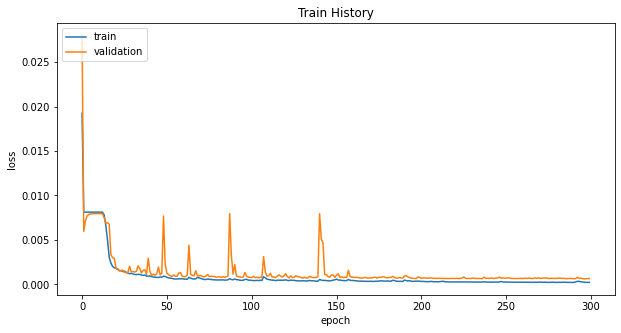

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Train History')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [6]:
model.load_weights(weight_path)
model.compile(loss='MSE')
scores = model.evaluate(test_image, test_label)
print('loss =', scores)

65/65 [==============================] - 1s 5ms/step - loss: 3.0801e-04
loss = 0.0003279177180957049


In [10]:
model_path = 'model/plate_corner_prediction_%dx%dx%d.h5' % INPUT_SHAPE
model.save(model_path)

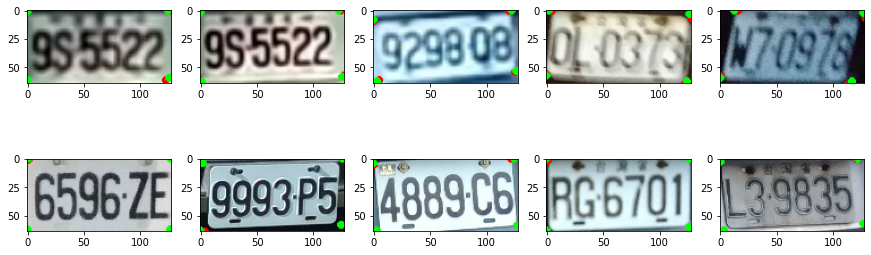

In [29]:
plt.figure(figsize=(15, 5))

for i in range(10):
    im = test_image[i].copy()
    lb = test_label[i].copy()
    h, w = im.shape[:2]
    
    pred = model.predict(np.array([im]))[0].reshape(4, 2)
    pred[:, 0] = (pred[:, 0]*w)
    pred[:, 1] = (pred[:, 1]*h)

    image = (im*255).astype('uint8')
    label = lb.reshape(4, 2)
    label[:, 0] = (label[:, 0]*w)
    label[:, 1] = (label[:, 1]*h)

    for x, y in label.astype(int):
        cv2.circle(image, (x, y), 2, (255, 0, 0), 2) # label = red
    for x, y in pred.astype(int):
        cv2.circle(image, (x, y), 2, (0, 255, 0), 2) # pred = green

    plt.subplot(2, 5, i+1); plt.imshow(image)
plt.show()